In [1]:
from collections import Counter

from pauli import SiteBasis, PauliSum, PauliString
from hamiltonians import transverse_field_ising_model, xyz_model

import picos as pc
import numpy as np
import seaborn as sns
from scipy.linalg import null_space, eigvalsh
from scipy.special import ellipeinc
from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt

%load_ext line_profiler

In [2]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def izxy_correspondence(word1: str) -> PauliSum:
    # Even count of X and Y
    mapping = {'I': 'Z', 'Z': 'I', 'X': 'Y', 'Y': 'X'}
    word2 = ''.join(mapping[c] for c in word1)
    return PauliSum({word1: 1.0j, word2: -1j * (-1j) ** ((word1.count('X') + word1.count('Y')) % 4)})

def beta_independent_constraints(basis: SiteBasis, hamil: PauliSum, use_izxy: bool = False) -> np.ndarray:
    # We handle normalization separately
    n_cols = basis.size() - 1
    A = np.zeros((n_cols, n_cols), dtype=complex)
    for i, word in enumerate(basis._ops[1:]):
        psum = schwinger_dyson(hamil, word)
        if psum.is_zero():
            continue
        for pstr, weight in psum.terms.items():
            A[i, basis.rank(str(pstr)) - 1] += weight
    if use_izxy:
        for i, word in enumerate(basis._ops[1:]):
            if word.count('X') % 2 != 0 or word.count('Y') % 2 != 0:
                continue
            psum = izxy_correspondence(word)
            for pstr, weight in psum.terms.items():
                A[i, basis.rank(str(pstr)) - 1] += weight
    return 1j * A

In [3]:
# Now decompose everything
def get_bases(L):
    basis = SiteBasis(L)
    small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
    return basis, small_basis

def decompose(op: PauliSum, A_ns, small_basis):
    res = np.zeros(A_ns.shape[1], dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res += weight * A_ns[small_basis.rank(str(pstr)) - 1, :]
    return res

def get_decomp(A_ns, ops, small_basis):
    decomp_mats = np.zeros((A_ns.shape[1], len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[:, i, j] += p1.phase(p2) * A_ns[small_basis.rank(str(p3)) - 1, :]
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

def decompose_sb(op: PauliSum, small_basis):
    res = np.zeros(small_basis.size() - 1, dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res[small_basis.rank(str(pstr)) - 1] += weight
    return res

def get_decomp_sb(ops, small_basis):
    decomp_mats = np.zeros((small_basis.size() - 1, len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[small_basis.rank(str(p3)) - 1, i, j] += p1.phase(p2)
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

def get_reorder(matrix):
    n_cc, labels = connected_components(csr_array(matrix), directed=False)
    reord = [y for y, _ in sorted(enumerate(labels), key=lambda x: x[1])]
    return n_cc, reord, labels.tolist()

In [26]:
def analytical_energy(h):
    return (2 * np.abs(1 - h) / np.pi) * ellipeinc(np.pi / 2, -4 * h / (1 - h) ** 2)

def dm_energy(L, h):
    prob = pc.Problem()
    hamil = transverse_field_ising_model(L, h)
    H = hamil.to_matrix()
    # H = csr_array(hamil.to_matrix())
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho | H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    # print(prob)
    return prob.solve(), rho

def dm_energies(L, hs):
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        # print(f'Solving {h:.4f}...')
        energies[i] = -dm_energy(L, h)[0].value / L
    return energies

def nnz(mat):
    return np.count_nonzero(~np.isclose(mat, 0))

def get_energy_problem(hamil, small_basis, As, Bs) -> pc.Solution:
    prob = pc.Problem()
    decomp_hamil = np.real(decompose_sb(hamil, small_basis))
    # This is the primal problem
    X = pc.HermitianVariable("X", As.shape[1])
    Y = pc.HermitianVariable("Y", Bs.shape[1])
    prob.set_objective("max", -(pc.trace(X) + pc.trace(Y)))
    prob.add_constraint(X >> 0)
    prob.add_constraint(Y >> 0)
    prob.add_list_of_constraints([(X | As[i]) + (Y | Bs[i]) == decomp_hamil[i] for i in range(As.shape[0])])
    return prob

def get_energies(L, hs):
    small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
    hamil = transverse_field_ising_model(L, 1)
    A = beta_independent_constraints(small_basis, hamil, use_izxy=True)
    A_ns = null_space(A)
    # Now build the ops from the sparsity pattern
    solve_basis = small_basis
    zero_ops = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
    sparsity = np.ones((solve_basis.size(), solve_basis.size()), dtype=np.int8)
    for i, o1 in enumerate(solve_basis._ops):
        for j, o2 in enumerate(solve_basis._ops):
            if i <= j:
                continue
            if small_basis.rank(str(PauliString(o1) * PauliString(o2))) - 1 in zero_ops:
                sparsity[i, j] = sparsity[j, i] = 0
    _, reord, labels = get_reorder(sparsity)
    label_counts = Counter(labels)
    spops1 = np.array(solve_basis._ops)[reord[:label_counts[0]]]
    spops2 = np.array(solve_basis._ops)[reord[label_counts[0]:]]
    As = get_decomp_sb(spops1, small_basis)
    Bs = get_decomp_sb(spops2, small_basis)
    energies = np.zeros_like(hs)
    # prob = get_energy_problem(transverse_field_ising_model(L, 1), small_basis, As, Bs)
    # print(prob)
    for i, h in enumerate(hs):
        print(f'Solving {h:.4f}...')
        hamil = transverse_field_ising_model(L, h)
        energies[i] = -get_energy_problem(hamil, small_basis, As, Bs).solve().value / L
    return energies

Solving 3
Solving 0.0000...
Solving 0.0202...
Solving 0.0404...
Solving 0.0606...
Solving 0.0808...
Solving 0.1010...
Solving 0.1212...
Solving 0.1414...
Solving 0.1616...
Solving 0.1818...
Solving 0.2020...
Solving 0.2222...
Solving 0.2424...
Solving 0.2626...
Solving 0.2828...
Solving 0.3030...
Solving 0.3232...
Solving 0.3434...
Solving 0.3636...
Solving 0.3838...
Solving 0.4040...
Solving 0.4242...
Solving 0.4444...
Solving 0.4646...
Solving 0.4848...
Solving 0.5051...
Solving 0.5253...
Solving 0.5455...
Solving 0.5657...
Solving 0.5859...
Solving 0.6061...
Solving 0.6263...
Solving 0.6465...
Solving 0.6667...
Solving 0.6869...
Solving 0.7071...
Solving 0.7273...
Solving 0.7475...
Solving 0.7677...
Solving 0.7879...
Solving 0.8081...
Solving 0.8283...
Solving 0.8485...
Solving 0.8687...
Solving 0.8889...
Solving 0.9091...
Solving 0.9293...
Solving 0.9495...
Solving 0.9697...
Solving 0.9899...
Solving 1.0101...
Solving 1.0303...
Solving 1.0505...
Solving 1.0707...
Solving 1.0909...


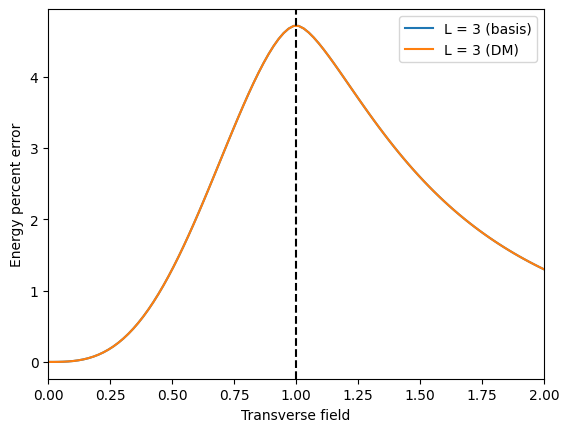

In [ ]:
Ls = [4]
hs = np.linspace(0, 2, num=100)
aE = analytical_energy(hs)
for L in Ls:
    print(f'Solving {L}')
    plt.plot(hs, 100 * np.abs(get_energies(L, hs) - aE) / aE, label=f'L = {L} (basis)')
    plt.plot(hs, 100 * np.abs(dm_energies(L, hs) - aE) / aE, label=f'L = {L} (DM)')
plt.axvline(1, linestyle='--', c='black')
plt.xlim(0,2)
plt.ylabel('Energy percent error')
plt.xlabel('Transverse field')
plt.legend()
plt.show()

In [41]:
def tfimgen(n):
    gens = set()
    xx = "XX" + "I" * (n - 2)
    z = "Z" + "I" * (n - 1)
    for j in range(n):
        gens.add(xx[j:] + xx[:j])
        gens.add(z[j:] + z[:j])
    return list(gens)

In [230]:
L = 6
sol, dm = dm_energy(L, 1)
rho = np.array(dm.value)
rho_ps = PauliSum.from_matrix(rho)

In [99]:
for op in rho_ps.terms.keys():
    if str(op).count('Y') % 2 != 0:
        print(op)

In [43]:
g = [PauliString(x) for x in tfimgen(L)]
gset = set(g)
for a in g:
    for b in g:
        c = a & b
        if c is not None and c not in gset:
            gset.add(c)
            g.append(c)
# print(len(g))
# print(SiteBasis(L, True, True).size())
cg = [str(x) for x in rho_ps.terms.keys()]
g = [str(x) for x in g]
g.sort()
cg.sort()
print(cg)
print(set(g) - set(cg))
print(set(cg) - set(g))

['III', 'IIZ', 'IXX', 'IYY', 'IZI', 'IZZ', 'XIX', 'XXI', 'XXZ', 'XZX', 'YIY', 'YYI', 'YYZ', 'YZY', 'ZII', 'ZIZ', 'ZXX', 'ZYY', 'ZZI', 'ZZZ']
set()
set()


In [44]:
print([str(x) for x in rho_ps.terms.keys()])

['III', 'IIZ', 'IZI', 'IZZ', 'IXX', 'IYY', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'ZXX', 'ZYY', 'XIX', 'XZX', 'XXI', 'XXZ', 'YIY', 'YZY', 'YYI', 'YYZ']


In [216]:
com = {}
small_basis = SiteBasis(L, True, True)
for pstr, weight in rho_ps.terms.items():
    rw = np.round(weight, 5)
    pnorm = small_basis.normalize(str(pstr))
    if rw in com:
        com[rw].add(pnorm)
    else:
        com[rw] = {pnorm}
print(*com.items(),sep='\n')

(np.complex128(0.125+0j), {'ZZZ', 'III'})
(np.complex128(0.08333+0j), {'IIZ', 'IZZ', 'IXX'})
(np.complex128(-0.04167+0j), {'IYY'})
(np.complex128(0.04167+0j), {'XXZ'})
(np.complex128(-0.08333+0j), {'YYZ'})


In [ ]:
small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
hamil = transverse_field_ising_model(L, 1)
A = beta_independent_constraints(small_basis, hamil, use_izxy=False)
A_ns = null_space(A)
zero_ops = set(small_basis.unrank(op + 1) for op in np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
nnz_ops = set(small_basis._ops) - zero_ops
miss_ops = nnz_ops - set([small_basis.normalize(str(op)) for op in rho_ps.terms.keys()])
miss_ops_izxy = set()
for op in miss_ops:
    mapping = {'I': 'Z', 'Z': 'I', 'X': 'Y', 'Y': 'X'}
    izxy_dual = lambda word1: ''.join(mapping[c] for c in word1)
    if small_basis.normalize(op) in miss_ops_izxy or small_basis.normalize(izxy_dual(op)) in miss_ops_izxy:
        continue
    miss_ops_izxy.add(op)
print(miss_ops_izxy)
print(len(nnz_ops))
print(A_ns.shape)

{'XYZXYZ', 'XXXYXY', 'IXYXIY', 'XYXZYZ', 'XZYYYZ', 'IIXYXY', 'IXIZYZ', 'IIXIYZ', 'IXYXYZ', 'IXIXYX', 'XYXYXY', 'IXYXZY', 'IXYZIZ', 'IXYZXY', 'IYXYYZ', 'IIYXZZ', 'IYXYXZ'}
147
(429, 45)


In [ ]:
small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
hamil = transverse_field_ising_model(L, 1)
A = beta_independent_constraints(small_basis, hamil, use_izxy=True)
A_ns = null_space(A)
zero_ops = set(small_basis.unrank(op + 1) for op in np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
nnz_ops = set(small_basis._ops) - zero_ops
print(len(nnz_ops))
print(A_ns.shape)

706
(1299, 39)


In [48]:
indicator = ~np.isclose(rho, 0)
n_cc, reord, labels = get_reorder(indicator)
print(n_cc)
reord_rho = rho[:, reord][reord, :]
reord_rho_ps=PauliSum.from_matrix(reord_rho)

5


In [49]:
small_basis = SiteBasis(L, True, True)
smod = set([small_basis.normalize(str(op)) for op in rho_ps.terms.keys()])
print(len(smod))
print(len(rho_ps.terms))
print(smod)

8
20
{'ZZZ', 'IIZ', 'IXX', 'YYZ', 'IYY', 'XXZ', 'IZZ', 'III'}


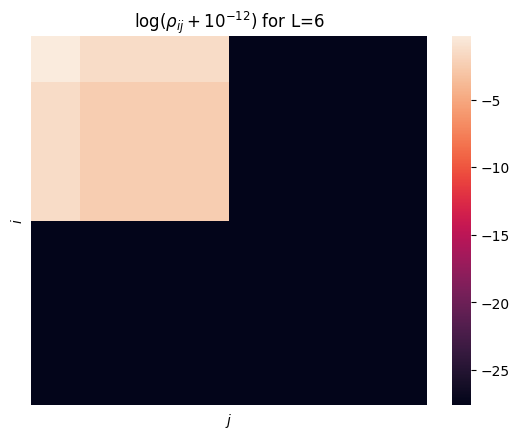

In [50]:
sns.heatmap(np.log(reord_rho + 1e-12), xticklabels=False, yticklabels=False)
plt.title(r'$\log(ρ_{ij} + 10^{-12})$ for L=6')
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')
plt.show()

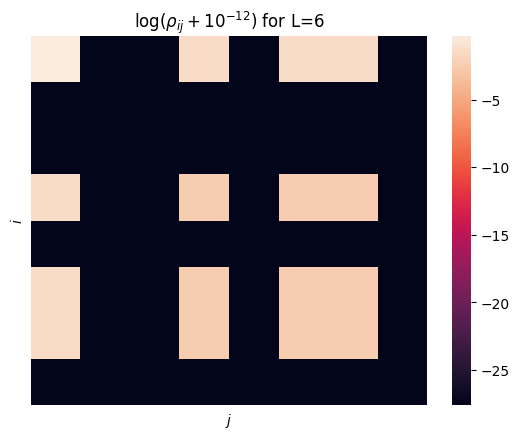

In [51]:
sns.heatmap(np.log(rho + 1e-12), xticklabels=False, yticklabels=False)
plt.title(r'$\log(ρ_{ij} + 10^{-12})$ for L=6')
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')
plt.show()

In [ ]:
def dm_tvals(L, h, Es):
    tvals = np.zeros_like(Es)
    hamil = transverse_field_ising_model(L, h)
    prob = pc.Problem()
    H = hamil.to_matrix()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    x = pc.RealVariable("x", H.shape[0])
    prob.set_objective("max", pc.lambda_min(rho))
    prob.add_constraint(pc.trace(rho) == 1)
    Y = pc.block([[rho, x],
                  [x.T, 1.0]])
    prob.add_constraint(Y >> 0)
    for i, E in enumerate(Es):
        print(f'Solving {E:.4f}...')
        Econs = (pc.trace(rho * H) == E)
        prob.add_constraint(Econs)
        if i == 3:
            print(prob)
        tvals[i] = prob.solve().value
        prob.remove_constraint(Econs)
    return tvals

def dm_tval(L, h, E):
    hamil = transverse_field_ising_model(L, h)
    H = hamil.to_matrix()
    prob = pc.Problem()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("max", pc.lambda_min(rho))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(pc.trace(rho * H) == E)
    sobj = prob.solve()
    return sobj.value, rho

In [ ]:
L, h = 3, 0.5
np.round(eigvalsh(transverse_field_ising_model(L, h).to_matrix()), 4)

array([-3.2321, -3.1458,  0.2321,  0.5   ,  0.5   ,  1.5   ,  1.5   ,
        2.1458])

In [293]:
Es = np.linspace(-3.2, 1, num=100)
ts = dm_tvals(L, h, Es)

Solving -3.2000...
Solving -3.1576...
Solving -3.1152...
Solving -3.0727...
Optimization Problem
  maximize λ_min(ρ)
  over
    8×1 real variable x
    8×8 symmetric variable ρ
  subject to
    tr(ρ) = 1
    [ρ, x; xᵀ, 1] ≽ 0
    tr(ρ·[8×8]) = -3.07273
Solving -3.0303...
Solving -2.9879...
Solving -2.9455...
Solving -2.9030...
Solving -2.8606...
Solving -2.8182...
Solving -2.7758...
Solving -2.7333...
Solving -2.6909...
Solving -2.6485...
Solving -2.6061...
Solving -2.5636...
Solving -2.5212...
Solving -2.4788...
Solving -2.4364...
Solving -2.3939...
Solving -2.3515...
Solving -2.3091...
Solving -2.2667...
Solving -2.2242...
Solving -2.1818...
Solving -2.1394...
Solving -2.0970...
Solving -2.0545...
Solving -2.0121...
Solving -1.9697...
Solving -1.9273...
Solving -1.8848...
Solving -1.8424...
Solving -1.8000...
Solving -1.7576...
Solving -1.7152...
Solving -1.6727...
Solving -1.6303...
Solving -1.5879...
Solving -1.5455...
Solving -1.5030...
Solving -1.4606...
Solving -1.4182...
Solvin

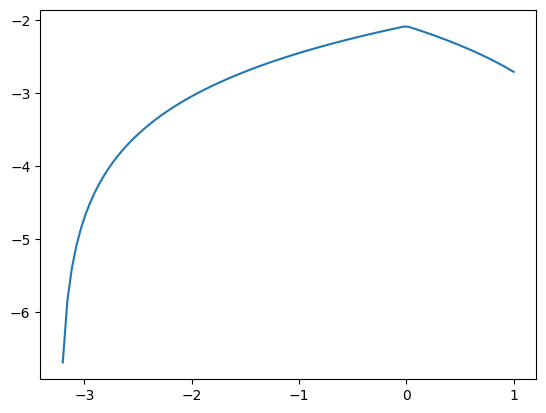

In [294]:
plt.plot(Es, np.log(np.abs(ts)))

In [ ]:
L, h, E = 8, 0.5, 0
t, dm = dm_tval(L, h, E)
print(t)

In [268]:
rho = np.array(dm.value)
rho_ps = PauliSum.from_matrix(rho)
print(rho_ps)

0.06+0.00j*IIII


In [270]:
dm_energy(L, h)[0].value

-6.38469456360371

In [ ]:
def spin_chain_rho(hamil: PauliSum):
    H = hamil.to_matrix()
    prob = pc.Problem()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho * H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    prob.solve()
    return np.array(rho.value)

In [210]:
L, h = 4, 1
rho = spin_chain_rho(xyz_model(L, h))
rho_ps = PauliSum.from_matrix(rho)

In [214]:
com = {}
small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
for pstr, weight in rho_ps.terms.items():
    rw = np.round(weight, 5)
    pnorm = small_basis.normalize(str(pstr))
    if rw in com:
        com[rw].add(pnorm)
    else:
        com[rw] = {pnorm}
print(*com.items(),sep='\n')

(np.complex128(0.0625+0j), {'IIII'})
(np.complex128(0.04419+0j), {'IIIZ', 'IIIX'})
(np.complex128(0.03125+0j), {'IIZZ', 'IXIZ', 'IXIX', 'IIXZ', 'IZIZ', 'IIXX'})
(np.complex128(0.0221+0j), {'IXXX', 'IXXZ', 'IZZZ', 'IXZX', 'IZXZ', 'IXZZ'})
(np.complex128(0.01563+0j), {'XXXX', 'ZZZZ'})
(np.complex128(0.01562+0j), {'XZZZ', 'XZXZ', 'XXZZ', 'XXXZ'})


In [ ]:
L = 5
hamil = transverse_field_ising_model(L, 1)
basis = SiteBasis(L)
small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
A = np.zeros((basis.size(), basis.size()), dtype=np.complex128)
for i, op in enumerate(basis._ops):
    p = PauliString(op)
    for pstr, weight in hamil.terms.items():
        u = p | pstr
        if u is not None:
            A[i, basis.rank(str(u))] += weight * p.phase(pstr)
A_ns = np.real(null_space(1j * A))

In [411]:
zero_ops_inds = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
zero_ops = set(small_basis.normalize(basis.unrank(i)) for i in zero_ops_inds)
nnz_opsf = small_basis._opset - zero_ops
# zero_ops = set(basis.unrank(i) for i in zero_ops_inds)
# nnz_ops = basis._opset - zero_ops
# print(len(zero_ops_inds))
# print(zero_ops)
print(len(nnz_opsf))
print(nnz_opsf)

108
{'IXYZZ', 'IXYZX', 'IXZZY', 'IYXYZ', 'IXYXZ', 'IIIIX', 'IIIYY', 'YZYZZ', 'IYXXY', 'IXYIZ', 'IIXYZ', 'IXXIY', 'IZYZZ', 'YYYZZ', 'XYYYY', 'IYZXZ', 'XZXZZ', 'IXXXX', 'IXIXY', 'IXIXZ', 'IYXXZ', 'IIXIX', 'IYYZZ', 'XXXZZ', 'IXXXZ', 'IYYIZ', 'XYXYZ', 'IZIZZ', 'IXXXY', 'XXYZY', 'XXXYZ', 'IIZZZ', 'IXZXZ', 'IXIYZ', 'IZXZZ', 'IYXZZ', 'XXYYZ', 'XXYZZ', 'IIXIY', 'ZZZZZ', 'IYXYY', 'IIIZZ', 'IXXZY', 'XYZZZ', 'XZYZZ', 'XZYYZ', 'IYIYZ', 'IIIII', 'XYYYZ', 'IIZYZ', 'IXXZZ', 'IXYXY', 'IIXIZ', 'IXYYY', 'IXZIY', 'IZXYZ', 'IXZYZ', 'IIYXZ', 'XYZYZ', 'IIYZY', 'IXXYX', 'YYZZZ', 'XXYXZ', 'XYXYY', 'IXXIZ', 'IIYIY', 'XXXXZ', 'IYZZZ', 'IXZYY', 'YZZZZ', 'IYYYY', 'YYYYZ', 'XXYXY', 'XXZXZ', 'IXZZX', 'IIIIZ', 'IZYYZ', 'IIXZY', 'IIZIZ', 'XYZXZ', 'IIIXZ', 'IXYZY', 'IIYIZ', 'IIYZZ', 'IYZZY', 'IXYYX', 'XYYXZ', 'IIYYY', 'XXXXY', 'IYIYY', 'IXYIY', 'IIXZZ', 'IIXXX', 'IIXXZ', 'XXZZZ', 'IIXYY', 'IZZZZ', 'IYYXZ', 'IYZYZ', 'IYYYZ', 'IXXYY', 'IIIXX', 'IIXZX', 'XYYZY', 'IIYYZ', 'IZXXZ', 'IXIZZ', 'IIIXY'}


In [412]:
A = beta_independent_constraints(small_basis, hamil, False)
A_ns = null_space(A)
zero_ops_inds = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
zero_ops = set(small_basis.unrank(i + 1) for i in zero_ops_inds)
nnz_ops = small_basis._opset - zero_ops
# print(len(zero_ops_inds))
# print(zero_ops)
print(len(nnz_ops))
print(nnz_ops)

44
{'IXZZX', 'IIIIZ', 'IZYYZ', 'IXIXZ', 'IIZIZ', 'IIYZY', 'IIXIX', 'IYYZZ', 'YYZZZ', 'IYZZY', 'IXYYX', 'XYYXZ', 'IYYIZ', 'IIIYY', 'YZYZZ', 'IXXIZ', 'XYXYZ', 'IZIZZ', 'IYXXY', 'XXYZY', 'XXYYZ', 'IIZZZ', 'IXZXZ', 'IIXXZ', 'IIYIY', 'XXXXZ', 'XXZZZ', 'ZZZZZ', 'IZZZZ', 'IYYYY', 'YYYYZ', 'IYZYZ', 'IIIZZ', 'IXXYY', 'IIIXX', 'IYIYZ', 'XZXZZ', 'IIIII', 'IIXZX', 'IXXXX', 'IXXZZ', 'IXYXY', 'IIYYZ', 'IZXXZ'}
